<a href="https://colab.research.google.com/github/DanielCastilloUna/GNC-Demostration-Python-/blob/main/GCN_DEMO_PYTHON_FV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Dataset: Cora():
Número de grafos: 1
Número de nodos: 2708
Número de clases: 7
Número de características por nodo: 1433
Epoch: 000, Loss: 1.9683, Train Acc: 0.5143, Val Acc: 0.3940, Test Acc: 0.4110
Epoch: 020, Loss: 0.3008, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.8070
Epoch: 040, Loss: 0.0484, Train Acc: 1.0000, Val Acc: 0.7960, Test Acc: 0.8020
Epoch: 060, Loss: 0.0433, Train Acc: 1.0000, Val Acc: 0.7860, Test Acc: 0.7940
Epoch: 080, Loss: 0.0475, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.7980
Epoch: 100, Loss: 0.0267, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.8060
Epoch: 120, Loss: 0.0350, Train Acc: 1.0000, Val Acc: 0.7760, Test Acc: 0.8040
Epoch: 140, Loss: 0.0402, Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.8020
Epoch: 160, Loss: 0.0339, Train Acc: 1.0000, Val Acc: 0.7760, Test Acc: 0.8030
Epoch: 180, Loss: 0.0319, Train Acc: 1.00

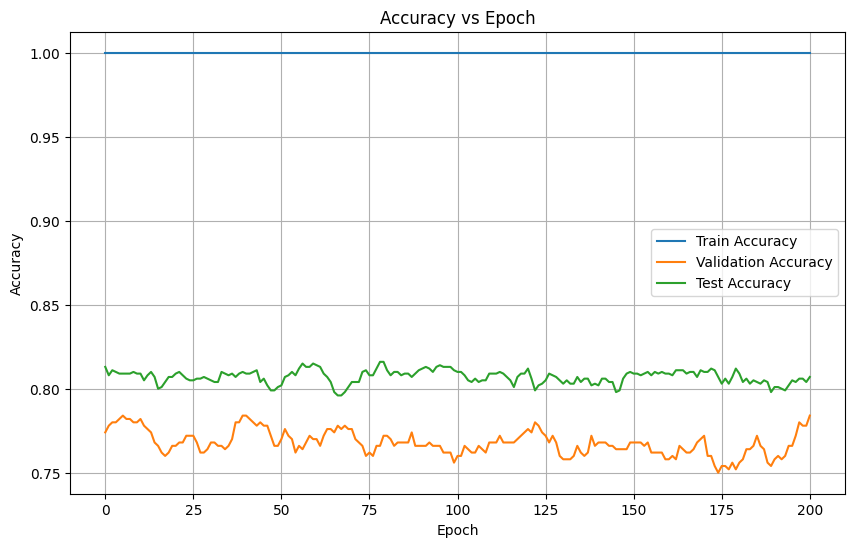

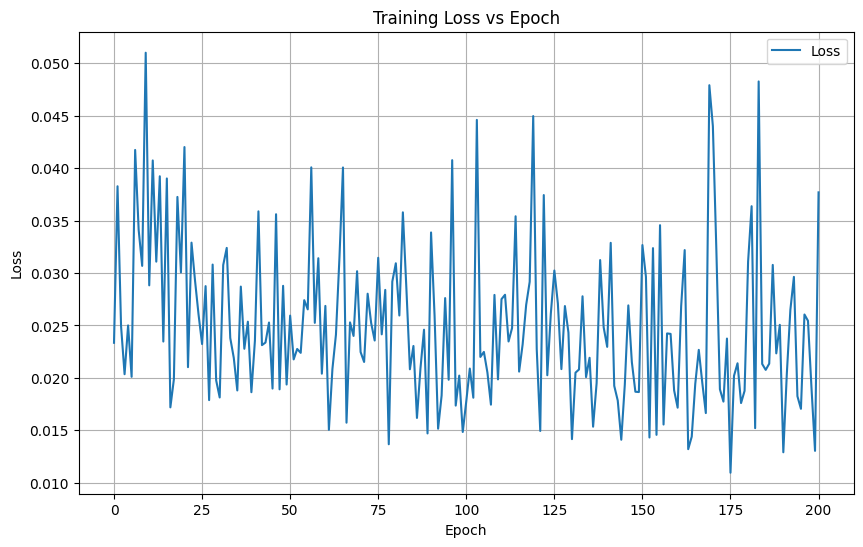

In [4]:
#Grupo 04-08 am

#Miembros: Daniel Castillo Jimenez - 402630359
#Fabián Varela Zamora – 119090803
#Sebastián Villalobos García – 118440258

#Demostracion en Python de Clasificacion de Nodos en un Grafo de citas (Cora dataset)



# Instalar PyTorch Geometric en Colab, que lo utilizamos para implementar
#(ACLARAMOS que el codigo aqui presentado fue desarrollado con la ayuda de Chat GPT y no lo adjudicamos a creacion 100% nuestra, lo usamos a  modo de guia)
#Nos enfocamos en explicar cada proceso paso a paso y con la ayuda de conocimientos vistos en clase los implementamos para complementar el trabajo

#Instalacion de librerias necesarias para usar GCNs, Requisitos del entorno utilizado
!pip install torch torchvision torchaudio
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric

#Importamos las librerias
import torch #Importa PyTorch, el framework para redes neuronales
import torch.nn.functional as F #Importa funciones de activacion, perdida
from torch_geometric.datasets import Planetoid #Permite descargar datasets estandar de grafos como Cora
from torch_geometric.nn import GCNConv #Importa la capa de Convolucion para Grafos

# Descargamos el dataset si no existe y lo guarda en data/Planetoid
dataset = Planetoid(root='data/Planetoid', name='Cora') #name = 'Cora', indicamos que queremos el dataset de citas de Cora
data = dataset[0] #Accede al primer y unico grafo del dataset, un objeto data que contiene features de los nodos, aristas, etiquetas(clases de los nodos)


# Vemos un poco de informacion de nuestro Cora en pantalla
print(f"Dataset: {dataset}:")
print(f"Número de grafos: {len(dataset)}")
print(f"Número de nodos: {dataset[0].num_nodes}")
print(f"Número de clases: {dataset.num_classes}")
print(f"Número de características por nodo: {dataset.num_node_features}")

#Definir modelo de GCN como una subclase de torch.nn.Module

class GCN(torch.nn.Module):
    def __init__(self): #Inicializamos el constructor
        super(GCN, self).__init__() #Llamamos al constructor de la clase base
        self.conv1 = GCNConv(dataset.num_node_features, 16) #Crea la primera capa con datos de entrada(numero de features del dataset(1433))
        self.conv2 = GCNConv(16, dataset.num_classes) #Entrada 16, con salida el numero de clases que serian 7

    def forward(self, data): #Propagacion, o es tambien decir como fluye la formacion
        x, edge_index = data.x, data.edge_index #Obtenemos los features de los nodos y sus aristas
        x = self.conv1(x, edge_index) #pasamos por la primera capa
        x = F.relu(x) #activamos Relu para evitar sobreajuste
        x = F.dropout(x, training=self.training) #Activamos dropout para evitar sobrejauste durante el entrenamiento del modelo
        x = self.conv2(x, edge_index) #pasamos por la segunda capa
        return F.log_softmax(x, dim=1) #aplicamos log softmax para obtener probabilidades en escala log

#Entrenar nuestro modelo, para ello debemos inicializarlo primero

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Selecciona GPU si hay, sino selecciona CPU para hacer el entrenamiento
model = GCN().to(device) #Creamos y movemos el modelo creado al dispositivo
data = data.to(device)
#Inicializacion del uso del optimizador Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) #lr = learning rate , weight_decay: regularizaciojn L2

def train(): #Ponemos el modelo creado en entrenamiento
    model.train() #Modo de entrenamiento, activa dropout
    optimizer.zero_grad() #Resetea los gradientes
    out = model(data) #Hacemos forward pass
    #Calculamos perdida solo en los nodos de entrenamiento
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward() #Aplicamos Backpropagation
    optimizer.step() #Actualizamos los pesos
    return loss.item() #devolvemos el valor de la perdida

def test(): #Evaluar el modelo creado, aca se desactiva el dropout
    model.eval() #Modo evaluacion, desactiva dropout
    out = model(data) #Forward pass
    pred = out.argmax(dim=1) #Prediccion: Clase con mayor probabilidad
    accs = [] #Lista para guardar los accuracies
    #Calculamos accuracie en train, val y test
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item() #Nodos correctos
        acc = correct / mask.sum().item() #Accuracy = correctos / total
        accs.append(acc) #A accuracies le incluimos el resultado
    return accs #Devolvemos las accuracies de estas 3

for epoch in range(201): #Repitimos el entrenamiento 201 epocas
    loss = train() #Entrenamos una epoca
    train_acc, val_acc, test_acc = test()
    #Cada 20 epocas mostramos metricas
    if epoch % 20 == 0: #Cada 20 epocas muestra perdida y precision en train/val/test
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

#Reporte de resultados

print(f"Final Test Accuracy: {test()[2]:.4f}")



#matplotlib es una biblioteca comunmente utilizada en la creacion de grafos y visualizacion de datos
#pyplot es un submódulo de matplotlib que proporciona una interfaz para la generaracion de gráficos de forma sencilla.
import matplotlib.pyplot as plt

#Almacenar las metricas obtenidas mediante listas
#Creacion de listas vacias
train_accuracies = []
val_accuracies = []
test_accuracies = []
losses = []

#For para los ciclos de entrenamiento del dataSet, donde en cada epoch el modelo aprende y actualiza los parametros internos
for epoch in range(201):
    loss = train()#Llama a una función llamada train() que probablemente entrena el modelo en una época.
    #Devuelve un valor de pérdida (loss), que mide qué tan bien o mal está funcionando el modelo en el entrenamiento.
    losses.append(loss)#Guarda el valor de loss en la lista losses, lo que permite seguir el historial de pérdidas a lo largo del entrenamiento.
    train_acc, val_acc, test_acc = test()#Llama a la función test() que evalúa el modelo.
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)#Agrega cada una de las precisiones (train_acc, val_acc, test_acc) a sus respectivas listas

    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
        #Muestra el número de la época (epoch) como número entero (d) con al menos 3 dígitos, rellenando con ceros si es necesario.
        #Muestran las precisiones de perdida, entrenamiento, validación y prueba, con 4 cifras decimales.
# Graficar accuracy
plt.figure(figsize=(10,6))#Crea una nueva figura para el gráfico con un tamaño de 10 pulgadas de ancho y 6 de alto.
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
#Dibuja tres curvas en el gráfico:

#Una con los valores de precisión de entrenamiento (train_accuracies).

#Otra con los valores de precisión de validación (val_accuracies).

#Otra con los valores de precisión de prueba (test_accuracies).

#Cada línea tendrá una etiqueta (label) para la leyenda.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#Añade etiquetas a los ejes:

#Eje X: número de épocas.

#Eje Y: valor de precisión.
plt.legend()#Muestra una leyenda para identificar cada línea del gráfico según sus etiquetas.
plt.title('Accuracy vs Epoch')#Establece un título para el gráfico.
plt.grid(True)#Activa la cuadrícula del gráfico para facilitar la lectura.
plt.show()#Muestra el gráfico completo en pantalla.

# Graficar loss
plt.figure(figsize=(10,6))#Crea una nueva figura para el gráfico con un tamaño de 10 pulgadas de ancho por 6 de alto.
plt.plot(losses, label='Loss')
#Dibuja una línea con los valores de pérdida almacenados en la lista losses.
#La etiqueta 'Loss' se usará para la leyenda.
plt.xlabel('Epoch')
plt.ylabel('Loss')
#Agrega etiquetas a los ejes:
#Eje X: representa las épocas del entrenamiento.
#Eje Y: representa el valor de la pérdida.
plt.title('Training Loss vs Epoch')#Asigna un título al gráfico: "Training Loss vs Epoch".
plt.grid(True)#Activa la cuadrícula en el fondo del gráfico para mejorar la visualización.
plt.legend()#Muestra la leyenda (en este caso, solo tendrá la etiqueta 'Loss').
plt.show()#Muestra el gráfico final en pantalla.


